<a href="https://colab.research.google.com/github/Veronika2311/NNmethods_21/blob/main/hw2/cnn_6_Part4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

понятное [видео](https://www.youtube.com/watch?v=bNb2fEVKeEo) со стенфордского курса, из [материалов](https://cs231n.github.io/convolutional-networks) по которому взяты иллюстрации.

Датасет из [курса](https://github.com/DanAnastasyev/DeepNLP-Course/blob/master/Week%2004/Week_04_Convolutional_Neural_Networks.ipynb) Даниила Анастасьева.

Использовались [материалы](https://github.com/mannefedov/hse_ml_m1/blob/master/7_cnn/cnn.ipynb) из курса Михаила Нефедова.

# Сверточный слой




Желтое - фильтр (= filter,kernel).

Зеленое - входные данные, например, изображение.

Розовое - карта активации (activation map).

Каждый элемент в розовой матрице - результат поэлементного умножения фильтра на числа из области на входных данных.
Обучаемые параметры - элементы фильтра.

![Conv](https://image.ibb.co/e6t8ZK/Convolution.gif)



Чтобы не терять размер матрицы используется паддинг.

![padding](https://3deep.ru/wp-content/uploads/2020/01/keras_conv2d_padding.gif)

from https://3deep.ru/machinelearning/

# Pooling слой  (не обучается)

![Pool](https://cs231n.github.io/assets/cnn/pool.jpeg)
![maxpool](https://cs231n.github.io/assets/cnn/maxpool.jpeg)

# Свертки для текстов устроены немного по-другому. В них на одну размерность меньше.

![text-convs](https://image.ibb.co/bC3Xun/2018_03_27_01_24_39.png)

From [Character-Aware Neural Language Models](https://arxiv.org/pdf/1508.06615.pdf)

# CNN для обработки текстов



In [54]:
!pip install torchmetrics

In [55]:
!pip install ipdb

In [56]:
import pandas as pd
import numpy as np
from string import punctuation
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
from torchmetrics import F1
from torchmetrics.functional import f1, recall
import ipdb
from tqdm import tqdm

### Слова



### Скачивание и подготовка данных

Давайте не будем заново, мы их уже предобработали и в файл сохранили

In [57]:
train_data =  pd.read_csv('train.csv')
val_data = pd.read_csv('val.csv')

In [58]:
train_data[train_data.type == 1].shape[0] / train_data.shape[0]

0.5079447203826343

In [59]:
train_data.head(50)

,Unnamed: 0,text,type,clean_texts
0,0,"эх, ехать на репу пора((\nЗавтра уже выступление.",0,"эх , ехать на репа пора ( ( завтра уже выступл..."
1,1,"Аллергия вышла,из-за этих тупых мандарин(((((((",0,"аллергия выйти , из - за этот тупой мандарин (..."
2,2,@KompaundTone550 @tatysho власть всегда была б...,1,"власть всегда была , просто теперь об знать ве..."
3,3,"@Alinockaa А хрен, я гулящая пока, потом насиж...",1,"а хрен , я пока , потом дома : dd но сегодня я..."
4,4,"RT @vik_vans: блин, слушала первый мини-альбом...",0,"rt @vik_vans : блин , слушать первый мини - ал..."
5,5,Как же не сделать фото на айфон в зеркале:-D h...,1,как же не сделать фото на айфон в
6,6,Заебись погулял... Мама пуховик постирала ;((,0,заебись погулял ... мама пуховик постирать ; ( (
7,7,#HappyBirthdayLouisfromCIS Почему я мало пиш...,0,# почему я мало писать в тви ; ( ( ( (
8,8,@cobyisnotalone ладно :(\nмне через полтора ча...,0,ладно :( мне через полтора час только
9,9,"@DashaSone вот да, это было бы идеально! Хочу ...",1,"вот да , это было бы идеальный ! хотеть все пр..."


Почему мы можем трогать только train_data? Потому что иначе может попасть что-нибудь из теста. Вероятно, будет не очень заментно, но исключать возможность не стоит, и на уровне слов она больше, чем на уровне символов

In [60]:
vocab = Counter()
for text in tqdm(train_data['clean_texts']):
    vocab.update(str(text).split(' '))
print('всего уникальных слов:', len(vocab))

100%|██████████| 173952/173952 [00:01<00:00, 164353.38it/s]

всего уникальных слов: 18112


In [61]:
vocab['PAD']

0

In [62]:
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 5:
        filtered_vocab.add(word)
    else:
        print(word) # мы всё в препроцессинге удалили
print('уникальных слов, встретившихся больше 5 раз:', len(filtered_vocab))

уникальных слов, встретившихся больше 5 раз: 18112


In [63]:
#создаем словарь с индексами symbol2id, для спецсимвола паддинга дефолтный индекс - 0
word2id = {'PAD':0}
symbol2id = {'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)
    for symbol in word:
        if not symbol in symbol2id.keys():
            symbol2id[symbol] = len(symbol2id)

In [64]:
#symbol2id # И ещё смайлики

In [65]:
#обратный словарь для того, чтобы раскодировать последовательность
id2word = {i:word for word, i in word2id.items()}
id2symbol = {i:symbol for symbol, i in symbol2id.items()}

In [66]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
DEVICE

device(type='cuda')

In [67]:
word2id[')'] # у нас есть скобочки, и это важно

84

In [68]:
symbol2id[')']

59

## Эмбеддинги

Фасттекст так фасттекст, давайте возьмём для него леммы

In [69]:
from gensim.models import FastText

In [70]:
fasttext_data = [str(i) for i in train_data['clean_texts'].tolist()]

In [71]:
model_fasttext = FastText(fasttext_data, size=64, window=5, min_count=5)

In [72]:
#model_fasttext.wv[')'] #есть скобочки в модели!

In [73]:
model_embs = np.zeros((len(word2id), 64))
dict_of_non_wodel_embs = {} # логичнее для одинаковых слов использовать одинаковые эмбеддинги
len_non_model_words  = 0
# почему не случайные? потому что сейчас менять будем
for word, i in word2id.items():
    try:
        model_embs[i] = ft.wv[word]
    except:
        len_non_model_words += 1
        if word in dict_of_non_wodel_embs.keys():
            emb = dict_of_non_wodel_embs[word]
        else:
            emb = np.random.normal(0, 0.05, 64)
            dict_of_non_wodel_embs[word] = emb
        model_embs[i] = emb
print(len_non_model_words)

18113


### Dataset & DataLoader

In [74]:
class TweetsDataset(Dataset):

    def __init__(self, dataset, word2id, DEVICE):
        self.dataset = [str(i) for i in dataset['clean_texts'].values]
        self.word2id = word2id
        self.symbol2id = symbol2id
        self.length = dataset.shape[0]
        self.target = dataset['type'].values
        self.device = DEVICE

    def __len__(self):
        return self.length

    def __getitem__(self, index): 
        words = self.dataset[index].split(' ')
        symbols = list(self.dataset[index])
        words_ids = torch.LongTensor([self.word2id[word.lower()] for word in words if word.lower() in self.word2id])
        symbols_ids = torch.LongTensor([self.symbol2id[symbol.lower()] for symbol in symbols if symbol.lower() in self.symbol2id])
        y = [self.target[index]]
        return words_ids, symbols_ids, y

    def collate_fn(self, batch): #этот метод можно реализовывать и отдельно,
    # он понадобится для DataLoader во время итерации по батчам
        words_ids, symbols_ids, y = list(zip(*batch))
        
        padded_words_ids = pad_sequence(words_ids, batch_first=True).to(self.device)
        padded_symbols_ids = pad_sequence(symbols_ids, batch_first=True).to(self.device)
        y = torch.Tensor(y).to(self.device)
        return padded_words_ids, padded_symbols_ids, y

### создаем итераторы по данным для трейна и теста

In [75]:
train_dataset = TweetsDataset(train_data, word2id, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, sampler=train_sampler, batch_size=64)

In [76]:
batch = next(iter(train_iterator))

In [77]:
batch[0].shape

torch.Size([64, 36])

In [78]:
#[id2word[int(i)] for i in batch[0][0]]

In [79]:

batch[1]

tensor([[35, 50, 10,  ...,  0,  0,  0],
        [11, 17, 14,  ...,  0,  0,  0],
        [23,  2, 50,  ...,  0,  0,  0],
        ...,
        [26, 33, 72,  ...,  0,  0,  0],
        [20,  2,  5,  ...,  0,  0,  0],
        [26, 33, 72,  ...,  0,  0,  0]], device='cuda:0')

In [80]:
val_dataset = TweetsDataset(val_data, word2id, DEVICE)
val_sampler = SequentialSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn = val_dataset.collate_fn, sampler=val_sampler, batch_size=64)

In [81]:
test_batch = next(iter(val_iterator))
test_batch[0].shape

torch.Size([64, 34])

### CNN model

In [82]:
fm = torch.randn(3, 8, 4) #batch_size, num_filters, seq_len
fm

tensor([[[ 0.7730, -0.5823,  0.5370,  0.0596],
         [ 0.4840, -1.1157,  1.4484,  0.0114],
         [-0.3345,  0.4625, -0.0791, -0.1215],
         [-0.3722,  0.7536, -2.1020, -0.4278],
         [-0.1973, -0.1449,  1.3555,  1.0643],
         [ 0.7417,  0.3055, -0.7577,  1.2755],
         [ 1.2109, -0.7057,  1.4951,  0.6605],
         [ 1.3237,  0.3714, -0.3790,  1.0558]],

        [[-0.2410,  0.5852, -0.9284,  0.0786],
         [ 0.2254, -1.4330,  1.3916, -0.0292],
         [ 1.0274,  1.0500, -1.8175,  0.1152],
         [ 0.0863, -0.8421, -0.8687,  0.0928],
         [ 0.4675, -0.2433, -0.1908,  0.7938],
         [ 0.7992,  1.4567,  1.5456, -0.6798],
         [-0.5444, -0.1444, -0.9595, -0.6082],
         [-1.2961, -0.4826, -1.1602,  0.2445]],

        [[ 0.9157, -0.2864,  0.2406,  0.7466],
         [-0.1913,  0.0877,  0.2646,  1.2703],
         [ 0.4920, -2.1965, -0.0646,  1.0652],
         [-0.5397,  0.3300, -2.5417,  0.8493],
         [ 0.3165, -1.0688, -0.1884,  0.7469],
         

In [83]:
mp = torch.nn.MaxPool1d(kernel_size=2, stride=2)
print(mp(fm).shape)
mp(fm)

torch.Size([3, 8, 2])


tensor([[[ 0.7730,  0.5370],
         [ 0.4840,  1.4484],
         [ 0.4625, -0.0791],
         [ 0.7536, -0.4278],
         [-0.1449,  1.3555],
         [ 0.7417,  1.2755],
         [ 1.2109,  1.4951],
         [ 1.3237,  1.0558]],

        [[ 0.5852,  0.0786],
         [ 0.2254,  1.3916],
         [ 1.0500,  0.1152],
         [ 0.0863,  0.0928],
         [ 0.4675,  0.7938],
         [ 1.4567,  1.5456],
         [-0.1444, -0.6082],
         [-0.4826,  0.2445]],

        [[ 0.9157,  0.7466],
         [ 0.0877,  1.2703],
         [ 0.4920,  1.0652],
         [ 0.3300,  0.8493],
         [ 0.3165,  0.7469],
         [ 0.9462,  0.3245],
         [ 1.2865,  0.4105],
         [ 0.2424,  1.2524]]])

In [84]:
fm.max(2)[0]

tensor([[ 0.7730,  1.4484,  0.4625,  0.7536,  1.3555,  1.2755,  1.4951,  1.3237],
        [ 0.5852,  1.3916,  1.0500,  0.0928,  0.7938,  1.5456, -0.1444,  0.2445],
        [ 0.9157,  1.2703,  1.0652,  0.8493,  0.7469,  0.9462,  1.2865,  1.2524]])

Оставим фасттекст

In [110]:

class CNN(nn.Module):
    
    def __init__(self, words_vocab_size, symbols_vocab_size, words_embedding_dim, symbols_embedding_dim, model_embs):
        super().__init__()
        self.words_embedding = nn.Embedding(words_vocab_size, words_embedding_dim)
        self.words_embedding.from_pretrained(torch.tensor(model_embs), freeze=True) # ничего нового, только название
        self.hidden_words = nn.Linear(words_embedding_dim, out_features=100)
        
        self.symbols_embedding = nn.Embedding(symbols_vocab_size, symbols_embedding_dim)        
        self.bigrams = nn.Conv1d(in_channels=symbols_embedding_dim, out_channels=100, kernel_size=2, padding='same')
        self.trigrams = nn.Conv1d(in_channels=symbols_embedding_dim, out_channels=80, kernel_size=3, padding='same')
        
        #self.concat_bigrams = nn.Conv1d(in_channels=180, out_channels=100, kernel_size=2, padding='same')
        self.pooling = nn.MaxPool1d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.hidden = nn.Linear(in_features=280, out_features=1)
        self.dropout = nn.Dropout(p=0.5)
        self.out = nn.Sigmoid()

    def forward(self, symbols, words):
        #batch_size x seq_len
        embedded_words = self.hidden_words(torch.mean(self.words_embedding(words), dim=1))
        
        embedded_symbols = self.symbols_embedding(symbols)
        
        #batch_size x seq_len x embedding_dim
        embedded_symbols = embedded_symbols.transpose(1,2)
        #batch_size x embedding_dim x seq_len
        feature_symbols_bigrams = self.dropout(self.pooling(self.relu(self.bigrams(embedded_symbols))))
        #batch_size x filter_count2 x seq_len* 
        feature_symbols_trigrams = self.dropout(self.pooling(self.relu(self.trigrams(embedded_symbols))))
        #batch_size x filter_count3 x seq_len*
        #feature_symbols_bigrams = self.relu(self.bigrams(embedded_symbols))
        # batch_size x filter_count3 x seq_len*
        #feature_symbols_trigrams = self.relu(self.trigrams(embedded_symbols))

        pooling1 = feature_symbols_bigrams.max(2)[0] 
        # batch_size x filter_count2
        pooling2 = feature_symbols_trigrams.max(2)[0]
        # batch_size x filter_count3
        concat = torch.cat((pooling1, pooling2, embedded_words), 1)
        
        #feature_map_concat = self.relu(self.concat_bigrams(concat))
        #pooling = feature_map_concat.max(2)[0]
        # batch _size x (filter_count2 + filter_count3)
        logits = self.hidden(concat)
        logits = self.out(logits)
        
        return logits

In [92]:
words_batch, sym_batch, y = next(iter(train_iterator))
words_batch, sym_batch, y = words_batch.to(device='cpu'), sym_batch.to(device='cpu'), y.to(device='cpu')
print(words_batch)

tensor([[ 7490, 16756, 16211,  ...,     0,     0,     0],
        [ 4619,  1222,  7678,  ...,     0,     0,     0],
        [13595, 14875, 13206,  ...,     0,     0,     0],
        ...,
        [ 5127, 10846, 14072,  ...,     0,     0,     0],
        [ 3770,  9894, 14987,  ...,     0,     0,     0],
        [ 6083,  1162,  2541,  ...,     0,     0,     0]])


In [93]:
y

tensor([[0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.]])

In [94]:
model_embs.shape

(18113, 64)

In [100]:
words_batch.shape

torch.Size([64, 32])

In [102]:
sym_batch.shape

torch.Size([64, 107])

In [111]:
model = CNN(len(id2word), len(id2symbol), 64, 8, model_embs)
output = model(sym_batch, words_batch)
print(output)

tensor([[0.4912],
        [0.6073],
        [0.5758],
        [0.4641],
        [0.4609],
        [0.5261],
        [0.6272],
        [0.5180],
        [0.4707],
        [0.5963],
        [0.4994],
        [0.5765],
        [0.5147],
        [0.4725],
        [0.4358],
        [0.4282],
        [0.4308],
        [0.5389],
        [0.4395],
        [0.4217],
        [0.4103],
        [0.3607],
        [0.5537],
        [0.5738],
        [0.5467],
        [0.5217],
        [0.4459],
        [0.5882],
        [0.4280],
        [0.4794],
        [0.3884],
        [0.5588],
        [0.4537],
        [0.4495],
        [0.4779],
        [0.5412],
        [0.5292],
        [0.3996],
        [0.5537],
        [0.5238],
        [0.4131],
        [0.4603],
        [0.4751],
        [0.4835],
        [0.5381],
        [0.6080],
        [0.4542],
        [0.5191],
        [0.5076],
        [0.3580],
        [0.4808],
        [0.5295],
        [0.5183],
        [0.5296],
        [0.4920],
        [0

In [112]:
loss = nn.BCELoss()
loss(output, y)

tensor(0.6614, grad_fn=<BinaryCrossEntropyBackward0>)

In [113]:
f1(output, y.long())

tensor(0.5614)

### training loop, логика обучения и валидации

теперь нам нужны функции для обучения и валидации,
каждый вызов функции - одна эпоха обучения 

За одну эпоху нам надо для каждого батча:

-- применить к нему модель, 

-- посчитать значение функции потерь, 

-- посчитать градиенты,

-- обновить веса (параметры модели)


In [114]:
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0 # для подсчета среднего лосса на всех батчах

    model.train()  # ставим модель в обучение, явно указываем, что сейчас надо будет хранить градиенты у всех весов

    for i, (words_batch, sym_batch, ys) in enumerate(iterator): #итерируемся по батчам
        optimizer.zero_grad()  #обнуляем градиенты
        preds = model(sym_batch, words_batch)  #прогоняем данные через модель
        loss = criterion(preds, ys) #считаем значение функции потерь  
        loss.backward() #считаем градиенты  
        optimizer.step() #обновляем веса 
        epoch_loss += loss.item() #сохраняем значение функции потерь
        if not (i + 1) % int(len(iterator)/5):
            print(f'Train loss: {epoch_loss/i}')      
    return  epoch_loss / len(iterator) # возвращаем среднее значение лосса по всей выборке

In [115]:
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_metric = 0
    model.eval() 
    with torch.no_grad():
        for i, (words_batch, sym_batch, ys) in enumerate(iterator):   
            preds = model(sym_batch, words_batch)  # делаем предсказания на тесте
            loss = criterion(preds, ys)   # считаем значения функции ошибки для статистики  
            epoch_loss += loss.item()
            batch_metric = f1(preds.round().long(), ys.long(), ignore_index=0)
            epoch_metric += batch_metric

            if not (i + 1) % int(len(iterator)/5):
                print(f'Val loss: {epoch_loss/i}, Val f1: {epoch_metric/i}')
        
    return epoch_metric / len(iterator), epoch_loss / len(iterator) # возвращаем среднее значение по всей выборке

### инициализируем модель, задаем оптимизатор и функцию потерь

In [117]:
model = CNN(len(id2word), len(id2symbol), 64, 8, model_embs)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.BCELoss()

# веса модели и значения лосса храним там же, где и все остальные тензоры
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

### запуск обучения!

In [119]:
%%time
losses = []
losses_eval = []
f1s = []
f1s_eval = []

for i in range(5):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    f1_on_train,_ = evaluate(model, train_iterator, criterion)
    f1s.append(f1_on_train)
    print('\nEvaluating on test...')
    f1_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)


starting Epoch 0
Training...
Train loss: 0.03336500457330775
Train loss: 0.03285195315718084
Train loss: 0.031776731904608675
Train loss: 0.03132973357436978
Train loss: 0.0305810742445543

Evaluating on train...
Val loss: 0.030032047587451163, Val f1: 0.9869920015335083
Val loss: 0.028932623519864756, Val f1: 0.986644983291626
Val loss: 0.0294229697053311, Val f1: 0.9860186576843262
Val loss: 0.02969735817875321, Val f1: 0.9857743978500366
Val loss: 0.029487473443965944, Val f1: 0.985834002494812

Evaluating on test...
Val loss: 0.03011804256519234, Val f1: 0.9928398728370667
Val loss: 0.030508149551860025, Val f1: 0.9885126948356628
Val loss: 0.030690049749732714, Val f1: 0.9873532652854919
Val loss: 0.030324709643078127, Val f1: 0.9869458079338074
Val loss: 0.030311036321940793, Val f1: 0.9863495826721191

starting Epoch 1
Training...
Train loss: 0.027717870072089222
Train loss: 0.027514823967207884
Train loss: 0.02722470232761303
Train loss: 0.02709792791208081
Train loss: 0.02724

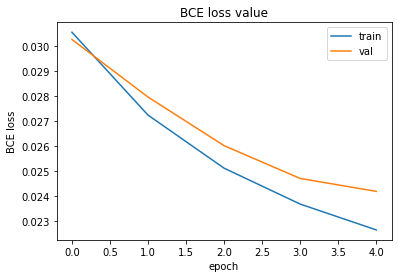

In [120]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.plot(losses_eval)
plt.title('BCE loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

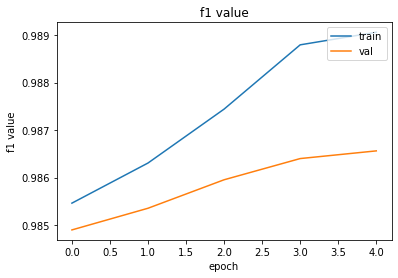

In [121]:
import matplotlib.pyplot as plt
plt.plot([i.cpu() for i in f1s])
plt.plot([i.cpu() for i in f1s_eval])
plt.title('f1 value')
plt.ylabel('f1 value')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

Ммм, мы даже не переобучились за четыре-то эпохи и с пунктуацией

Для анализа ошибок можно посмотреть на те примеры, которые мы (не)правильно предсказываем

In [130]:
def predict(model, iterator):
    model.eval()
    fp = []
    fn = []
    tp = [] 
    tn = []
    with torch.no_grad():
        for i, (words_batch, sym_batch, ys) in enumerate(iterator):   
            preds = model(sym_batch, words_batch)  # делаем предсказания на тесте 
            for pred, gold, text in zip(preds, ys, words_batch):
                text = ' '.join([id2word[int(word)] for word in text if word !=0])
                if round(pred.item()) > gold:
                    fp.append(text)
                elif round(pred.item()) < gold:
                    fn.append(text)
                elif round(pred.item()) == gold == 1:
                    tp.append(text)
                elif round(pred.item()) == gold == 0:
                    tn.append(text)
    return fp, fn, tp, tn

In [131]:
fp, fn, tp, tn = predict(model, val_iterator)

In [132]:
def get_metrics(fp, fn, tp, tn):
    all_preds = len(fp) + len(fn) + len(tp) + len(tn)
    print('accuracy')
    print((len(tp) + len(tn))/all_preds)
    print('precision')
    print(len(tp)/(len(fp) + len(tp)))
    print('recall')
    print(len(tp)/(len(fn) + len(tp)))

In [133]:
get_metrics(fp, fn, tp, tn)

accuracy
0.9866629874908021
precision
0.9887481778425656
recall
0.9848897359106997


In [134]:
print('действительно позитивные:', tp[:10])

действительно позитивные: ['вот да , ибо мой творческий натура не на простор контакт в ) :d', 'q : посмотреть страница вк :) a :', 'дуу бе шд тэ хэхэ дуу :-))', 'весь поздравлять с день администратор :)', '. :)', 'он смочь сделать это вечер . :-) # instantfollowback', 'была вчера в " " . там целый поляна - " рождественский звезда " . красотища ! :)', 'когда он писать в твой тетрадка , когда ты это восхитительный :*', 'энэ яасан намайг дээр бсан юм бэ : -):-):- )', 'мне всегда нравиться парень , которые старший меня :d я с ним иногда в вк переписываться , но в реал ни разу не разговаривать']


In [135]:
print('ошибочно негативные:', fn[:10])

ошибочно негативные: ['и первый проблема , с которой я столкнуться , это выбор : , стоить ли the sims 4 так рано ?', 'rt @igorg1975 : и медаль после : t ”', 'rt : а мне очень _', 'нифига ты тоже хотеть так', 'крутой варежка номер день !', 'нужный козёл и кто - то чтоб делать знать где быть , а я мочь делать', 'работа кать , кофта с высокий горло нет ?', 'rt : @ocheshuenaya ...', 'почему на нас орать на танец ? ? ? мы не виноватый в том что там были 69', 'ну чтож ... подвести итог - ты просто чудо , когда я тебя понимать . после пара вкусный и замечательный']


In [136]:
print('ошибочно позитивные:', fp[:10])

ошибочно позитивные: ['rt : смешной', 'наш следующий лето увидеть свой друг , родных , , дом , мой комната , ждать', 'че ты же мешать тебе', 'все как сговориться .. меня идти против себя', 'звонить на мобила , а то я в контакт теперь на что я на буду месяц два там', 'быть', 'ну ты твитере что белибер , но ... — я и белибер и что то иметь против это ?', 'у нас даже такой раньше было весёлый . я помнить к нам приходить и дед заставлять ребёнок рассказывать и песня петь', 'бог дать мне сила , пожалуйста и', ', что я любить не разбираться , а что же вообще такой любовь ?']


In [137]:
print('действительно позитивные:', tn[:10])

действительно позитивные: ['здесь стремно , такой звук :(', 'ну вот опять :( аж глаз ...', 'бляха , шо щас і , а вона не ( ( (', '# короче еще больше , чем ожидаться ( ( ( (', 'бля . зачем я это увидеть (', 'мороз стоять жуткий ( # крещение # # # photo # # # # путешествие @ …', 'полночь башка . и утро совсем разбить (', 'пойти выпью : ~ ( # ru_ff # ff_ru', 'смотреть концерт и понимать , что а мочь я так и не попасть на его концерт . ( ( ( (', 'блиииин , завтра и история ( ( ( (']
